In [271]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get Data

In [272]:
train = pd.read_csv('train.csv', header=False)
test = pd.read_csv('test.csv', header=False)

#Concatenate train and test samples ( test started with 892 Id )
full = pd.concat([train.drop('Survived', 1), test])

In [273]:
full[:5]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


### Prepare data

In [274]:
# Another one number of Nulls in each column
full.isnull().sum(axis=0)

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

In [275]:
# Fill empty Embarked values

embarked_maxs = full.groupby('Embarked').count()
max_emb = embarked_maxs.loc[embarked_maxs.PassengerId == embarked_maxs.PassengerId.max(), 'PassengerId'].argmax()
print max_emb

full.Embarked = full.Embarked.fillna(max_emb)

S


#### 1. Feature Engineering

In [276]:
import re
import math

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def get_deck(name):
    if not isinstance(name, str):
        return np.nan
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search('([A-Za-z]+)', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return np.nan

def get_cabin_pos(name):
    if not isinstance(name, str):
        return np.nan
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search('([0-9]+)', name)
    # If the title exists, extract and return it.
    if title_search:
        return int(title_search.group(1))
    return np.nan

In [277]:
# Get all the titles and print how often each one occurs.
titles = full["Name"].apply(get_title)

full["Title"] = titles
full.loc[ (full.Title == "Mme") | (full.Title == "Mlle"), "Title" ] = "Mlle"
full.loc[ (full.Title == "Capt") | (full.Title == "Don") | (full.Title == "Major") | (full.Title == "Sir"), "Title" ] = "Sir"
full.loc[ (full.Title == "Dona") | (full.Title == "Lady") | (full.Title == "Countess") | (full.Title == "Jonkheer"), "Title" ] = "Lady"

full.Title.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Dr          8
Rev         8
Sir         5
Col         4
Lady        4
Mlle        3
Ms          2
dtype: int64

In [278]:
full['Title2'] = full.Title
full['Title3'] = full.Title

In [279]:
# Generate FamilySize as a sum of parents, children and siblings

full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full.loc[full.FamilySize <= 2, 'FamilySize'] = 0

In [280]:
# Add feature 'is Mother'
full['Mother'] = 0
full.loc[ (full.Sex == 'female') & (full.Parch > 0) & (full.Age > 18) & (full.Title != 'Miss'), 'Mother' ] = 1

In [281]:
# Add feature 'is Child'

full['Child'] = 0
full.loc[ (full.Parch > 0) & (full.Age <= 18), 'Child' ] = 1

In [282]:
# Add feature 'Deck'
decks = full["Cabin"].apply(get_deck)
full["Deck"] = decks

In [283]:
# Get all numbers of a cabin and cluster them in 3 three groups
cabins = full["Cabin"].apply(get_cabin_pos)
full["CabinPos"] = cabins

#### 2. Fill (predict) Nulls

In [284]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for c in ['Embarked', 'Sex', 'Title', 'Title2', 'Title3']:
    full[c] = lbl_enc.fit_transform(full[c])

In [285]:
# Predict missing Fare values

from sklearn.tree import DecisionTreeRegressor
cols = ['Pclass', 'Title', 'Sex', 'SibSp', 'Parch']
clf = DecisionTreeRegressor(max_depth=5, max_features=0.5)
clf = clf.fit(full[cols].loc[full.Fare.notnull()], full.loc[full.Fare.notnull()].Fare)
full.loc[full.Fare.isnull(), 'Fare'] = clf.predict(full[cols].loc[full.Fare.isnull()])

In [286]:
# Predict missing Age values

from sklearn.tree import DecisionTreeRegressor
cols = ['Pclass', 'Title', 'Sex', 'SibSp', 'Parch', 'Fare']
clf = DecisionTreeRegressor(max_depth=5, max_features=0.5)
clf = clf.fit(full[cols].loc[full.Age.notnull()], full.loc[full.Age.notnull()].Age)
full.loc[full.Age.isnull(), 'Age'] = clf.predict(full[cols].loc[full.Age.isnull()])

In [287]:
# Predict missing Deck values

from sklearn.tree import DecisionTreeClassifier
cols = ['Pclass', 'Fare']
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(full[cols].loc[full.Deck.notnull()], full.loc[full.Deck.notnull()].Deck)
full.loc[full.Deck.isnull(), 'Deck'] = clf.predict(full[cols].loc[full.Deck.isnull()])

In [288]:
from sklearn.cluster import KMeans

numbers = full.loc[full.CabinPos.notnull(), 'CabinPos'].values.reshape(-1, 1)
clust = KMeans(n_clusters=3, init='k-means++', random_state=1).fit(numbers)
full.loc[full.CabinPos.notnull(), 'CabinPos'] = clust.labels_
full.fillna(-1, inplace=True)

In [289]:
# Replace labels with floats
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

for c in ['Deck']:
    full[c] = lbl_enc.fit_transform(full[c])
    
full[:3]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title2,Title3,FamilySize,Mother,Child,Deck,CabinPos
0,1,3,"Braund, Mr. Owen Harris",1,22,1,0,A/5 21171,7.2500,-1,2,6,6,6,0,0,0,5,-1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38,1,0,PC 17599,71.2833,C85,0,7,7,7,0,0,0,2,0
2,3,3,"Heikkinen, Miss. Laina",0,26,0,0,STON/O2. 3101282,7.9250,-1,2,4,4,4,0,0,0,4,-1


#### 3. Split data

In [290]:
train_filled = full.loc[full.PassengerId < 892]
test_filled = full.loc[full.PassengerId >= 892]

In [291]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Mother', 'Child', 'Deck', 'FamilySize', 'CabinPos']

In [318]:
cols = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'Mother', 'Child', 'Deck', 'Title2', 'Title3', 'Deck', 'FamilySize', 'CabinPos']

#### 4. Scale data

In [319]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_fit = scaler.fit_transform(train_filled[cols].values)
test_fit = scaler.transform(test_filled[cols].values)
train_fit[:3]

array([[ 0.82737724,  0.73769513, -0.54797103,  0.43279337, -0.47367361,
        -0.50244517,  0.58595414,  0.33110437, -0.24895491, -0.33312545,
         0.62712133,  0.33110437,  0.33110437,  0.62712133, -0.46921611,
        -0.50071238],
       [-1.56610693, -1.35557354,  0.62238773,  0.43279337, -0.47367361,
         0.78684529, -1.9423032 ,  1.10541931, -0.24895491, -0.33312545,
        -1.47349936,  1.10541931,  1.10541931, -1.47349936, -0.46921611,
         0.57951699],
       [ 0.82737724, -1.35557354, -0.25538134, -0.4745452 , -0.47367361,
        -0.48885426,  0.58595414, -1.21752551, -0.24895491, -0.33312545,
        -0.07308557, -1.21752551, -1.21752551, -0.07308557, -0.46921611,
        -0.50071238]])

## Try to evaluate score with different params of RF 

In [112]:
# Try to evaluate CV with RF Classifier

from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import time

best_score = 0
best_params = {}

time1 = time.time()
for feature in [3, 4, 5, 6, 7, 8, 'sqrt', 'log2']:
    for crt in ['gini', 'entropy']:
            for depth in [2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100, 250]:
                clf = RandomForestClassifier(n_estimators=1250, criterion=crt, oob_score=True, max_depth=depth, max_features=feature)
                score = cross_val_score(clf, train_fit, train.Survived).mean()
                if (score > best_score):
                    best_score = score
                    best_params = {'n_estimators': 1250, 'criterion': crt, 'max_features': feature, 'max_depth': depth}
time2 = time.time()
print("time: " + str((time2 - time1) * 1000.0))
print("score: " + str(best_score))
print("best_params: " + str(best_params))

time: 530485.253811
score: 0.833894500561
best_params: {'n_estimators': 10, 'max_features': None, 'criterion': 'entropy', 'max_depth': 10}


## Train RF and predict values for Test

In [325]:
# Train our classifier with optimal parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Try 
# 20 7 7 entropy
# and
# 5 7 15 gini
# best (0.80383) == 1250 est, 5 depth, 4 features, 'gini', OOB

rf = RandomForestClassifier(
                n_estimators=1250,
                criterion='entropy',
                oob_score=True,
                max_depth=5,
                max_features=4,
                random_state=42,
                class_weight='subsample',
                n_jobs=-1 )
rf.fit(train_fit, train.Survived)

# clf = BaggingClassifier(
#                 base_estimator=rf,
#                 n_estimators=1250,
#                 oob_score=True,
#                 #max_samples=5,
#                 max_features=4,
#                 bootstrap_features=True
# )
# clf.fit(train_fit, train.Survived)

RandomForestClassifier(bootstrap=True, class_weight='subsample',
            criterion='entropy', max_depth=5, max_features=4,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1250, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

Feature ranking:


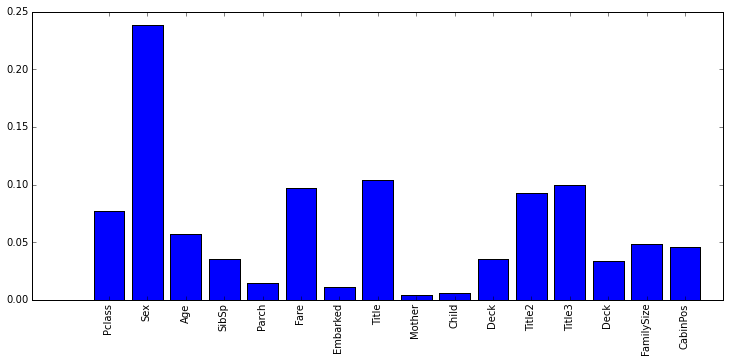

In [326]:
# Show feature importances
import pylab
import scipy

importances = rf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

labels = [cols[i] for i in indices.tolist()]
x = scipy.array(indices)
y = scipy.array(importances[indices])
f = pylab.figure(figsize=(12,5))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(x, y, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
f.show()


4 Important features(> 15 % of max importance):
['Pclass' 'Sex' 'Fare' 'Title']

Features sorted by importance (DESC):
['Sex' 'Title' 'Fare' 'Pclass']


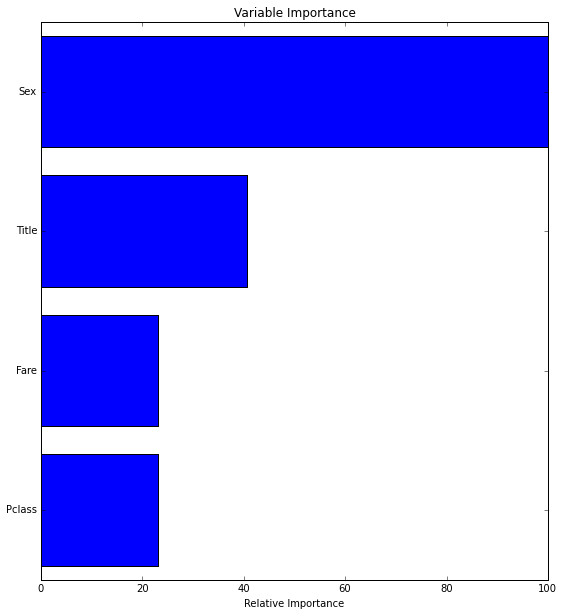

In [179]:
features_list = train_filled[cols].columns.values[0::]

feature_importance = rf.feature_importances_
 
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
 
# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 15
 
# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance > fi_threshold)[0]
 
# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]
print "\n", important_features.shape[0], "Important features(>", fi_threshold, "% of max importance):\n", \
        important_features

# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
print "\nFeatures sorted by importance (DESC):\n", important_features[sorted_idx]
 
# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()
 
# Remove non-important features from the feature set, and reorder those remaining
# X = X[:, important_idx][:, sorted_idx]

In [327]:
# Make a prediction with RF
prediction = rf.predict(test_fit)
prediction[:50]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1])

In [267]:
# Collect output to csv
submit = pd.read_csv('test.csv')[['PassengerId']]
submit['Survived'] = prediction
submit[:5]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [268]:
# Save it
submit.to_csv('submit.csv', index=False)